In [1]:
import json
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
# Load the JSON file
with open("./Sarcasm_Headlines_Dataset.json", 'r') as f:
    datastore = [json.loads(item) for item in f]

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [6]:
sentences[:5]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild",
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
 'j.k. rowling wishes snape happy birthday in the most magical way']

In [7]:
labels[:5]

[0, 0, 1, 1, 0]

In [8]:
len(sentences), len(labels)

(26709, 26709)

In [9]:
# Number of examples to use for training
TRAINING_SIZE = 20000

# Vocabulary size of the tokenizer
VOCAB_SIZE = 10000

# Maximum length of the padded sequences
MAX_LENGTH = 32

# Type of padding
PADDING_TYPE = 'pre'

# Specifies how to truncate the sequences
TRUNC_TYPE = 'post'

In [10]:
# Split the sentences
train_sentences = sentences[0:TRAINING_SIZE]
test_sentences = sentences[TRAINING_SIZE:]

# Split the labels
train_labels = labels[0:TRAINING_SIZE]
test_labels = labels[TRAINING_SIZE:]

In [11]:
# Instantiate the vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

# Generate the vocabulary based on the training inputs
vectorize_layer.adapt(train_sentences)

In [12]:
# Put the sentences and labels in a tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels))

In [13]:
def preprocessing_fn(dataset):
    '''Generates padded sequences from a tf.data.Dataset'''
    
    # Apply the vectorization layer to the string features
    dataset_sequences = dataset.map(
        lambda text, label: (vectorize_layer(text), label))
    
    # Put all elements in a single ragged batch
    dataset_sequences = dataset_sequences.ragged_batch(
        batch_size=dataset_sequences.cardinality())

    # Output a tensor from the single batch. Extract the sequences and labels.
    sequences, labels = dataset_sequences.get_single_element()

    # Pad the sequences
    padded_sequences = tf.keras.utils.pad_sequences(
                      sequences.numpy(),
                      maxlen=MAX_LENGTH,
                      truncating=TRUNC_TYPE,
                      padding=PADDING_TYPE
                      )

    # Convert back to a tf.data.Dataset
    padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)
    labels = tf.data.Dataset.from_tensor_slices(labels)

    # Combine the padded sequences and labels
    dataset_vectorized = tf.data.Dataset.zip(padded_sequences, labels)

    return dataset_vectorized

In [14]:
# Preprocess the train and test data
train_dataset_vectorized = train_dataset.apply(preprocessing_fn)
test_dataset_vectorized = test_dataset.apply(preprocessing_fn)

In [15]:
# View 2 training sequences and its labels
for example in train_dataset_vectorized.take(2):
  print(example)
  print()

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  319,    1,
        943, 4079, 2366,   47,  366,   94, 2026,    6, 2653, 9470])>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    4, 7185, 3128, 3305,
         28,    2,  152,    1,  358, 2902,    6,  236,    9,  844])>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)



In [16]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Optimize and batch the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

In [17]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

## Using LSTM

In [18]:
# Parameters
EMBEDDING_DIM = 16
LSTM_DIM = 32
DENSE_DIM = 24

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 32, 16)              │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 24)                  │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 174,129 (680.19 KB)

 Trainable params: 174,129 (680.19 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
NUM_EPOCHS = 10

# Train the model
history_lstm = model_lstm.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6866 - loss: 0.5403 - val_accuracy: 0.8524 - val_loss: 0.3472
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8941 - loss: 0.2604 - val_accuracy: 0.8490 - val_loss: 0.3800
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9307 - loss: 0.1872 - val_accuracy: 0.8460 - val_loss: 0.4479
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9553 - loss: 0.1337 - val_accuracy: 0.8438 - val_loss: 0.5567
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9683 - loss: 0.0954 - val_accuracy: 0.8386 - val_loss: 0.6569
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9804 - loss: 0.0625 - val_accuracy: 0.8392 - val_loss: 0.7870
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9876 - loss: 0.0451 - val_accuracy: 0.8347 - val_loss: 0.8663
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9920 - loss: 0.0299 - val_accuracy: 0.

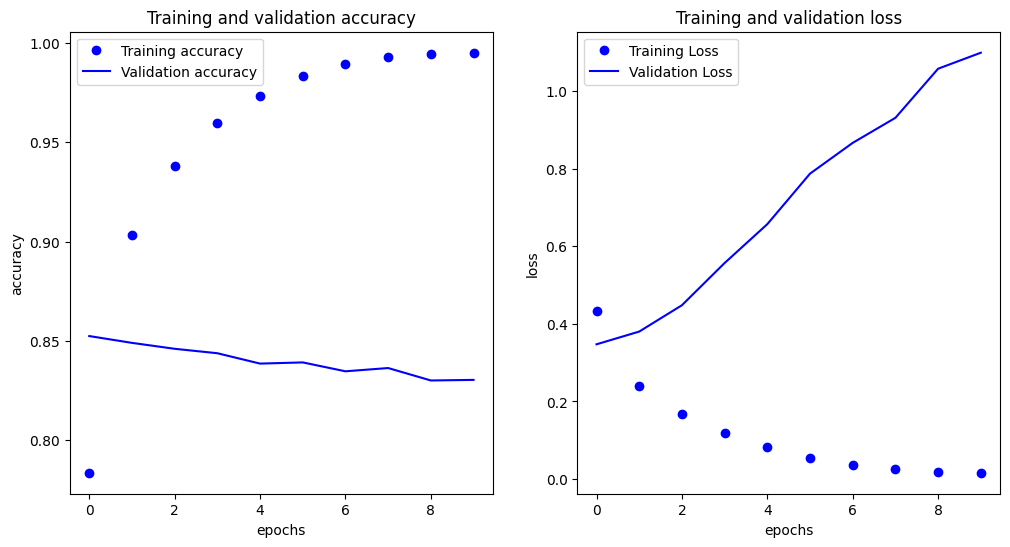

In [20]:
# Plot the accuracy and loss
plot_loss_acc(history_lstm)

In [27]:
# Changing the configuration a bit to see if we can reduce overfitting a little

# Parameters
EMBEDDING_DIM = 32
LSTM_DIM = 64
DENSE_DIM = 32
DROPOUT_RATE = 0.5
L2_REG = 0.01

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, mask_zero=True),
    tf.keras.layers.SpatialDropout1D(DROPOUT_RATE),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=True, recurrent_dropout=DROPOUT_RATE)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM, recurrent_dropout=DROPOUT_RATE)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
    tf.keras.layers.Dropout(DROPOUT_RATE),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

# Callbacks for early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)


# Train the model
history = model_lstm.fit(train_dataset_final, validation_data=test_dataset_final, epochs=10, batch_size=32, callbacks=[early_stopping])


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 32, 32)              │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 32, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 32, 128)             │          49,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 472,641 (1.80 MB)

 Trainable params: 472,641 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - accuracy: 0.6438 - loss: 0.9047 - val_accuracy: 0.8369 - val_loss: 0.4292
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.8541 - loss: 0.3967 - val_accuracy: 0.8459 - val_loss: 0.3747
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.8897 - loss: 0.3035 - val_accuracy: 0.8517 - val_loss: 0.3670
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.9131 - loss: 0.2537 - val_accuracy: 0.8556 - val_loss: 0.3941
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.9238 - loss: 0.2249 - val_accuracy: 0.8562 - val_loss: 0.4210
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.9368 - loss: 0.1908 - val_accuracy: 0.8545 - val_loss: 0.4427
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.9446 - loss: 0.1739 - val_accuracy: 0.8532 - val_loss: 0.4695
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.9510 - loss: 0.1531 - 

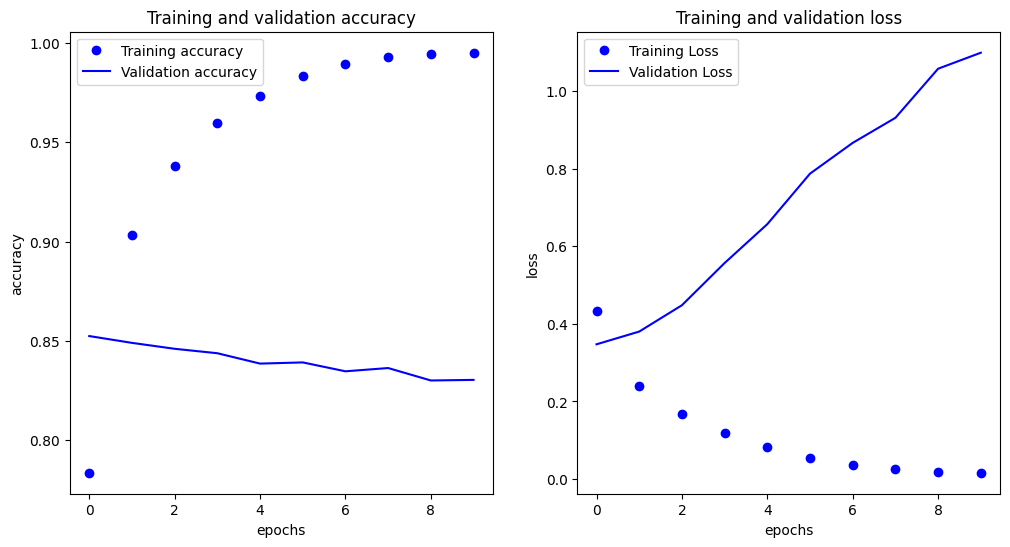

In [28]:
# Plot the accuracy and loss
plot_loss_acc(history_lstm)

## Using Conv1D

In [21]:
# Parameters
EMBEDDING_DIM = 16
FILTERS = 128
KERNEL_SIZE = 5
DENSE_DIM = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Conv1D(FILTERS, KERNEL_SIZE, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 32, 16)              │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 28, 128)             │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,149 (668.55 KB)

 Trainable params: 171,149 (668.55 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
NUM_EPOCHS = 10

# Train the model
history_conv = model_conv.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6891 - loss: 0.5443 - val_accuracy: 0.8477 - val_loss: 0.3415
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8949 - loss: 0.2579 - val_accuracy: 0.8533 - val_loss: 0.3713
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9483 - loss: 0.1494 - val_accuracy: 0.8498 - val_loss: 0.4577
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9783 - loss: 0.0736 - val_accuracy: 0.8444 - val_loss: 0.5742
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9920 - loss: 0.0316 - val_accuracy: 0.8435 - val_loss: 0.6821
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9973 - loss: 0.0127 - val_accuracy: 0.8407 - val_loss: 0.7664
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9992 - loss: 0.0055 - val_accuracy: 0.8360 - val_loss: 0.8479
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9995 - loss: 0.0027 - val_accuracy: 0.

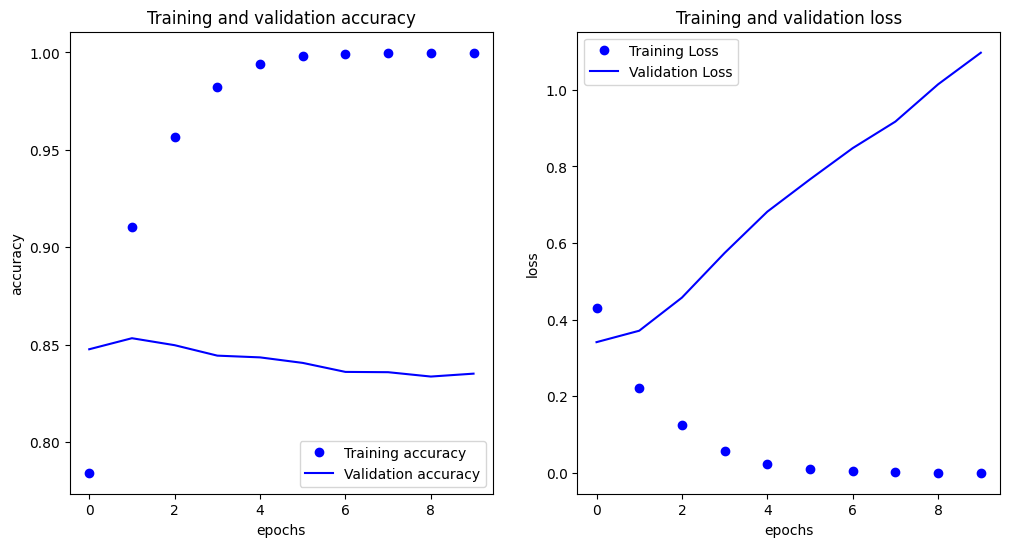

In [23]:
plot_loss_acc(history_conv)